In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import constants as const
from astropy import units as u 
import h5py
import os

dir_in = os.path.dirname(os.getcwd())

In [2]:
# Print with LaTeX typography. TeX Live package is needed.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer modern"],  # You can change the serif font here if needed
    "axes.labelsize": 14,     # Adjust as needed
    "axes.linewidth": 0.5,    # Adjust line width if necessary
    "xtick.labelsize": 12,    # Adjust tick label size
    "ytick.labelsize": 12,    # Adjust tick label size
    "legend.fontsize": 12,    # Adjust legend font size
    "legend.handlelength": 2.0
})

In [10]:
# CODE IN THIS CELL IS CREDITED TO COSMOS2020-READCAT (https://github.com/cosmic-dawn/cosmos2020-readcat)

def dust_ext(w,law=0,ebv=0.):
    
    law1 = np.loadtxt(str(dir_in)+"/Processing_COSMOS2020_catalogue/SB_calzetti.dat").T
    law2 = np.loadtxt(str(dir_in)+"/Processing_COSMOS2020_catalogue/extlaw_0.9.dat").T
    ext_w = [law1[0],law2[0]]
    ext_k = [law1[1],law2[1]]
    if ebv>0.:
        k = np.interp(w,ext_w[law],ext_k[law])
        return np.power(10.,-0.4*ebv*k)
    else:
        return 1.

hdf = h5py.File(str(dir_in)+"/Processing_COSMOS2020_catalogue/COSMOS2020_LePhare_v2_20210507_LIB_COMB.hdf5","r")

# m ranges from 1 to 12 (SED templates from BC03)
# t ranges from 0 to 41 and is refered to a list of different ages (in years)

def flam_mod(m,t):
    return hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA 

def wvl(m):
    return hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA 

def fnu_mod(m,t):
    flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA 
    fnu_mod = flam_mod*(wvl(m)**2)/const.c 
    fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl(m))
    return fnu_mod

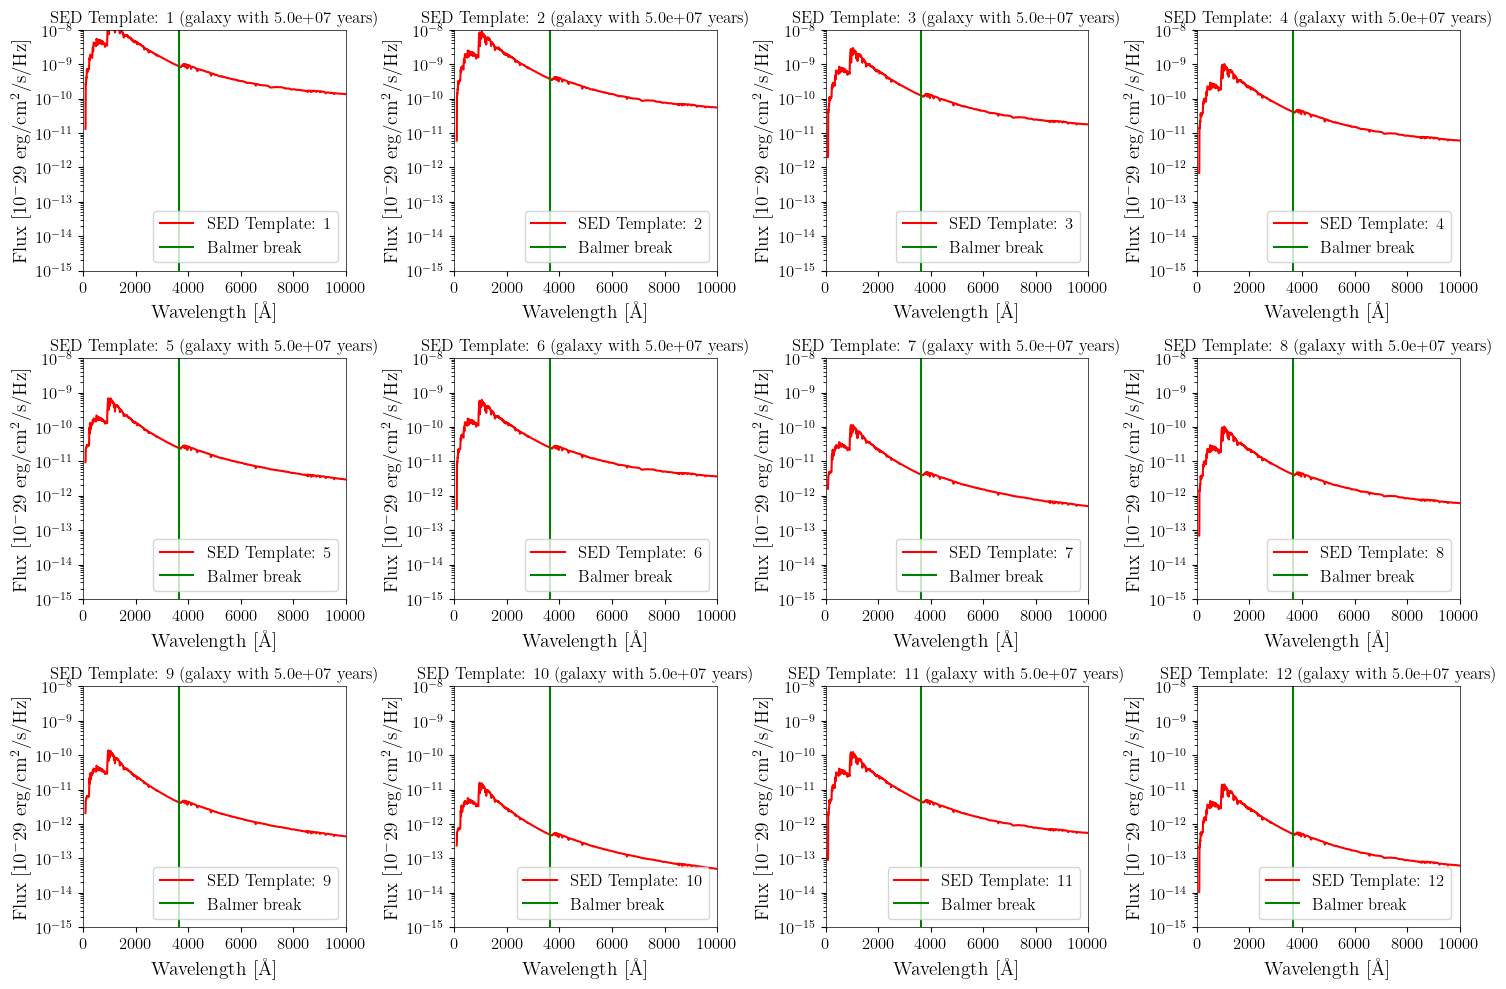

In [4]:
steps = 1

for k in range(steps):
    t=k
    m=0
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(3):
        for j in range(4):
            ax = axes[i, j]
            # Plot some sample data on each subplot
            m += 1
            ax.plot(wvl(m), flam_mod(m,t),c='r',label='SED Template: '+str(m))
            ax.set_title('SED Template: '+str(m)+' (galaxy with '+str("%.1e"%hdf['/model{}'.format(m)].attrs['age'][t])+' years)')
            ax.set_xlabel('Wavelength [Å]')
            ax.set_ylabel('Flux ['+f'$10^{-29}$ erg/cm$^2$/s/Hz]')
            ax.set_xlim(0,10000)
            ax.set_ylim(10**(-15),10**(-8))
            ax.axvline(3645,c='g',label='Balmer break')
            ax.set_yscale("log")
            ax.legend(loc='lower right')
    
    plt.tight_layout()
    
    #plt.savefig("%02.d"%k+".png",bbox_inches='tight')
    
    plt.show()
    plt.close()

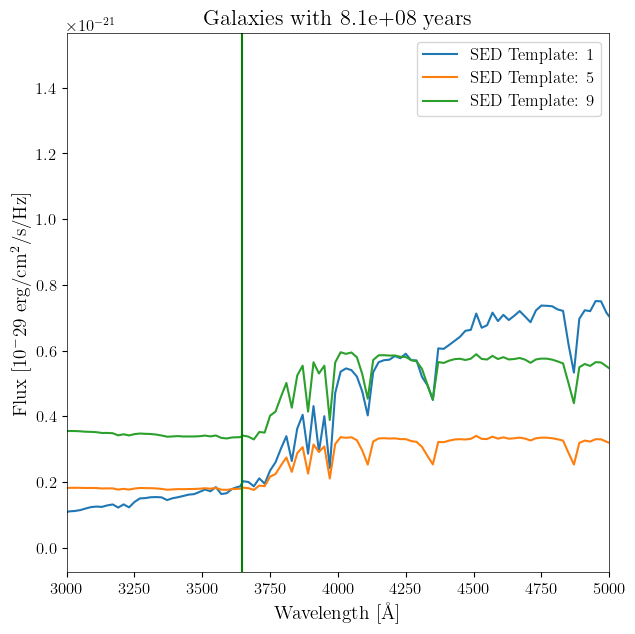

In [5]:
# PLOT SED OF SOME LP TEMPLATES BASED ON BC03 CLASSIFICATION [Bruzual & Charlot (2003)]

plt.figure(figsize=(7,7))

k=[1,5,9]
t=15
for m in k:
    plt.plot(wvl(m), fnu_mod(m,t),label='SED Template: '+str(m))

plt.title('Galaxies with '+str("%.1e"%hdf['/model{}'.format(m)].attrs['age'][t])+' years',fontsize=16)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux ['+f'$10^{-29}$ erg/cm$^2$/s/Hz]')
plt.xlim(3*10**3,5*10**3)
plt.axvline(3645,c='g')
plt.legend()
#plt.yscale("log")

plt.show()
plt.close()

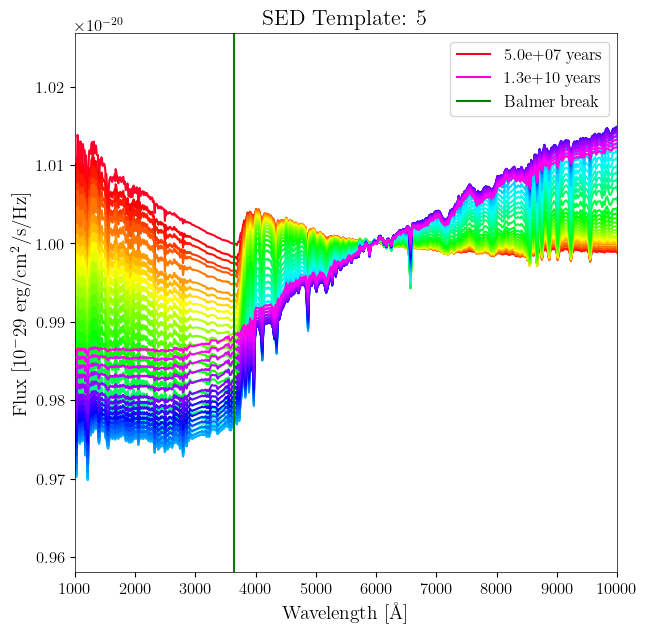

In [58]:
# PLOT OF ALL SEDs OF A UNIQUE GALAXY WITH A RAINBOW COLORMAP, MATCHING THEM IN 6010.0 Å (element 482 of the list where spectra data is)

def fnu_mod_rescaled(m,t):
    difference = (fnu_mod(m,t)[482].value-10**(-20)) *u.erg/u.cm/u.cm/u.s/u.Hz
    fnu_mod_rescaled = fnu_mod(m,t) - difference
    return fnu_mod_rescaled

plt.figure(figsize=(7,7))

# COLORMAP IDEA TAKEN FROM COSMOS2020-READCAT (https://github.com/cosmic-dawn/cosmos2020-readcat)
cm = plt.get_cmap('gist_rainbow')
cc = [cm(1.*i/42) for i in range(42)]

m = 5 # Number of the galaxy template used to plot
for t in range(42): # Plot for all ages of the galaxy
    if t==0 or t==41:
        label = str("%.1e"%hdf['/model{}'.format(m)].attrs['age'][t])+' years'
    else:
        label = None
    plt.plot(wvl(m), fnu_mod_rescaled(m,t),c=cc[t],label=label)
plt.title('SED Template: '+str(m),fontsize=16)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux ['+f'$10^{-29}$ erg/cm$^2$/s/Hz]')
plt.xlim(1*10**3,10*10**3)
plt.axvline(3645,c='g',label='Balmer break')
plt.legend()
#plt.yscale("log")

plt.show()

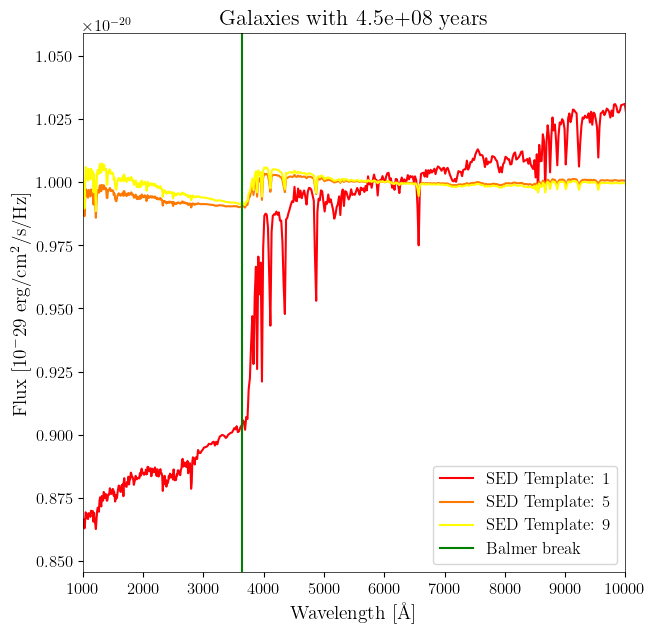

In [59]:
# PLOT OF SOME SEDs (associated to an age) OF A UNIQUE GALAXY WITH A RAINBOW COLORMAP, MATCHING THEM IN 6010.0 Å (element 482 of the list where spectra data is)

plt.figure(figsize=(7,7))

M = [1,5,9]

# COLORMAP IDEA TAKEN FROM COSMOS2020-READCAT (https://github.com/cosmic-dawn/cosmos2020-readcat)
cm = plt.get_cmap('gist_rainbow')
cc = [cm(1.*i/42) for i in range(42)]

t=10

for m in M:
    plt.plot(wvl(m), fnu_mod_rescaled(m,t),c=cc[m],label='SED Template: '+str(m))

plt.title('Galaxies with '+str("%.1e"%hdf['/model{}'.format(m)].attrs['age'][t])+' years',fontsize=16)
plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux ['+f'$10^{-29}$ erg/cm$^2$/s/Hz]')
plt.xlim(1*10**3,10*10**3)
plt.axvline(3645,c='g',label='Balmer break')
plt.legend()
#plt.yscale("log")

plt.show()

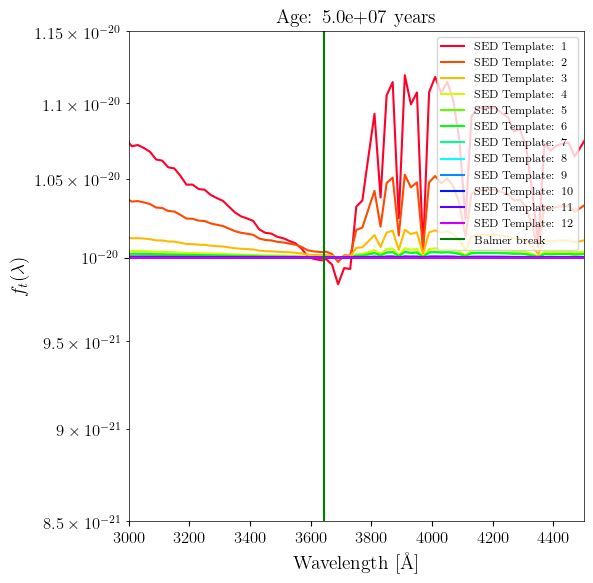

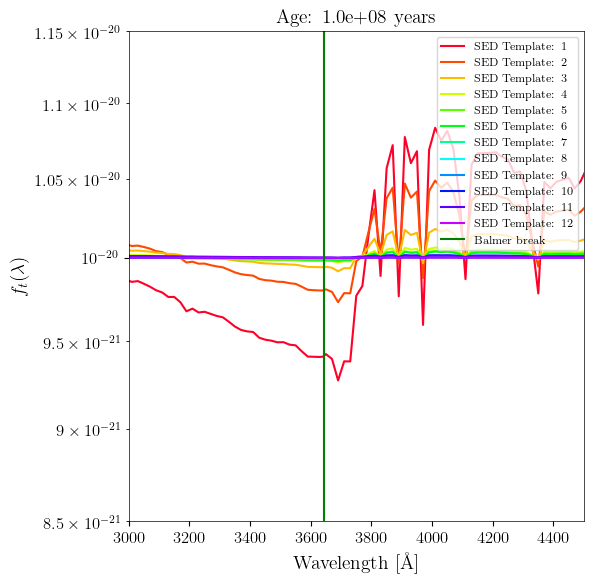

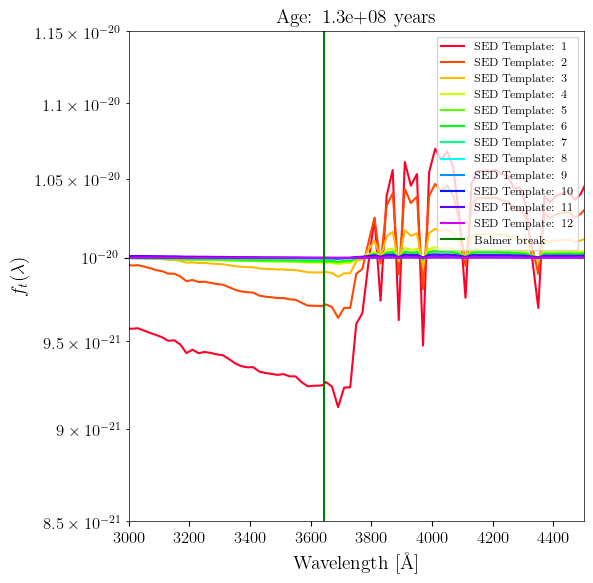

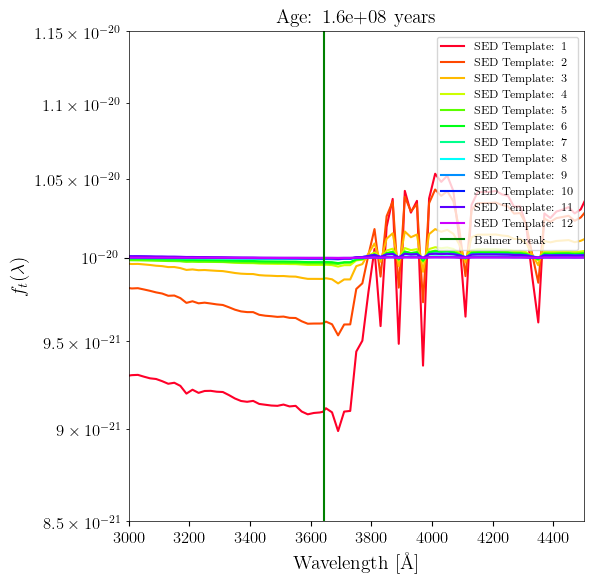

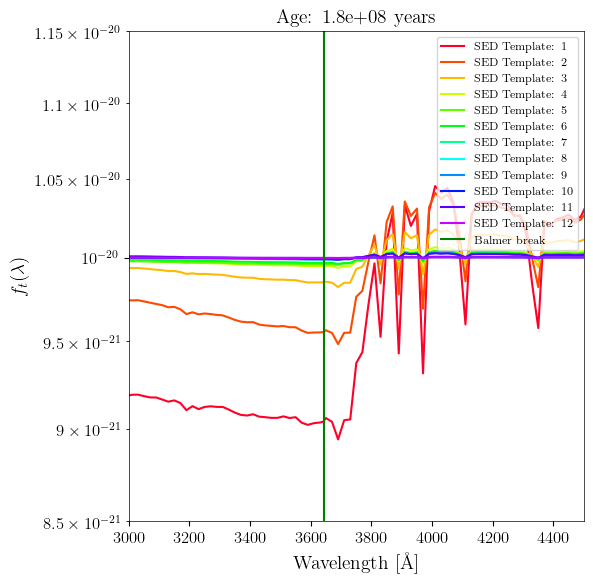

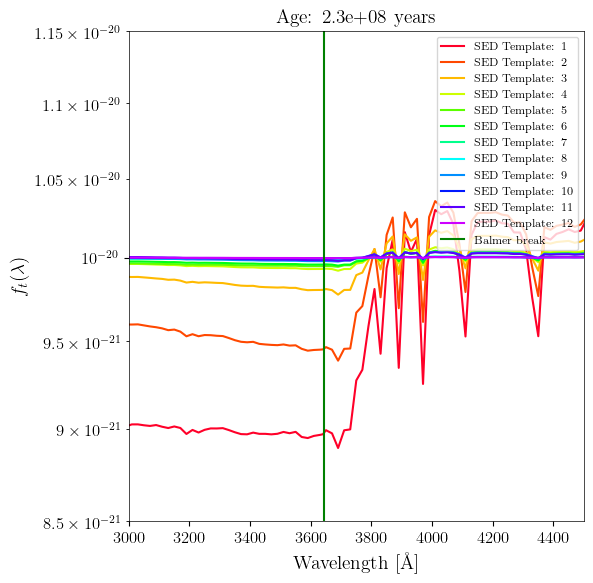

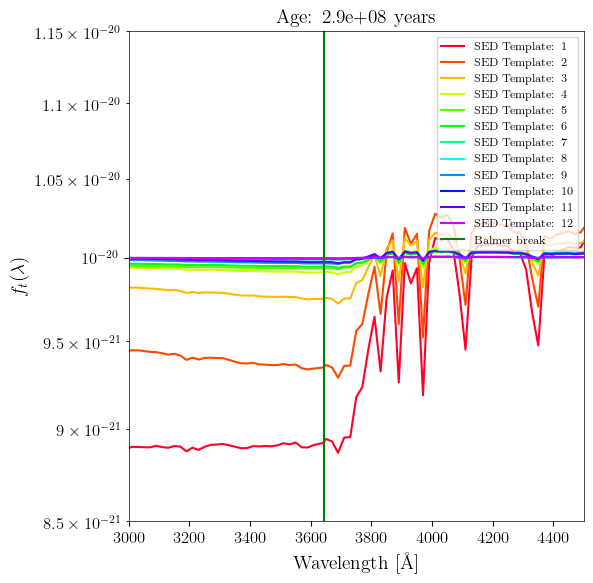

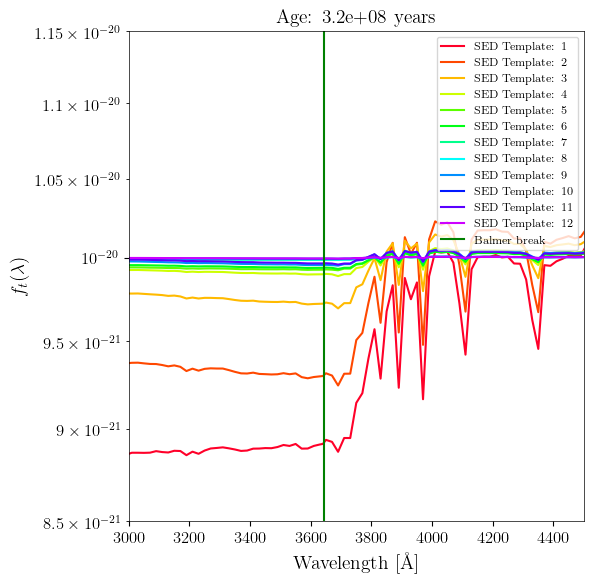

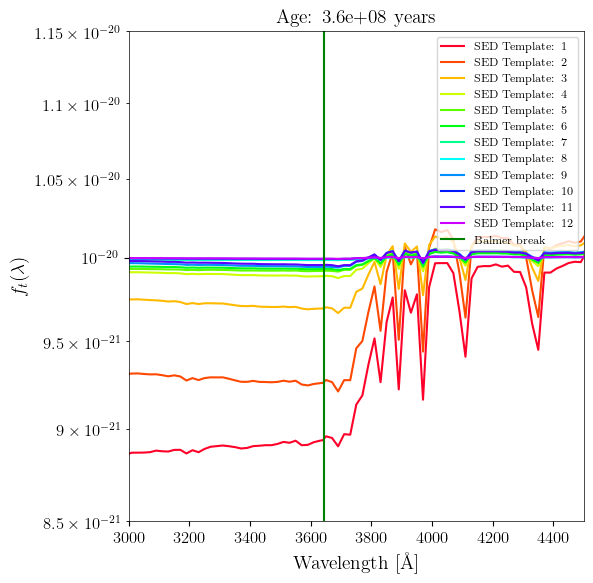

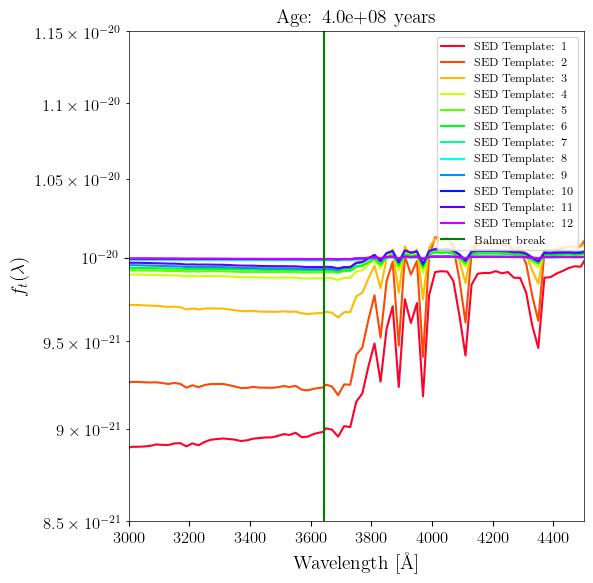

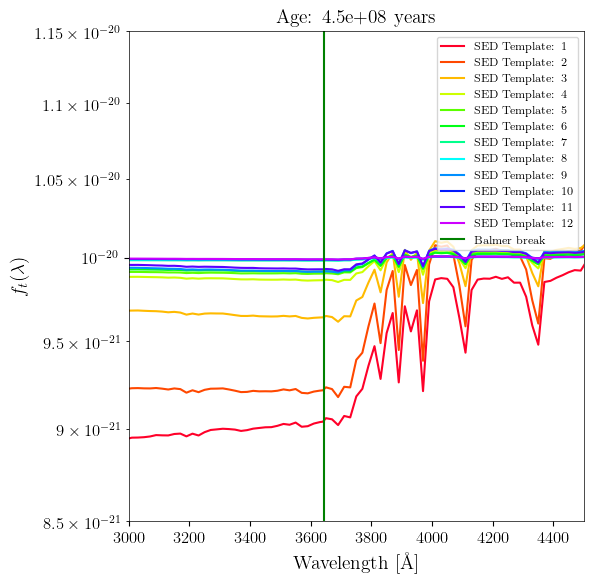

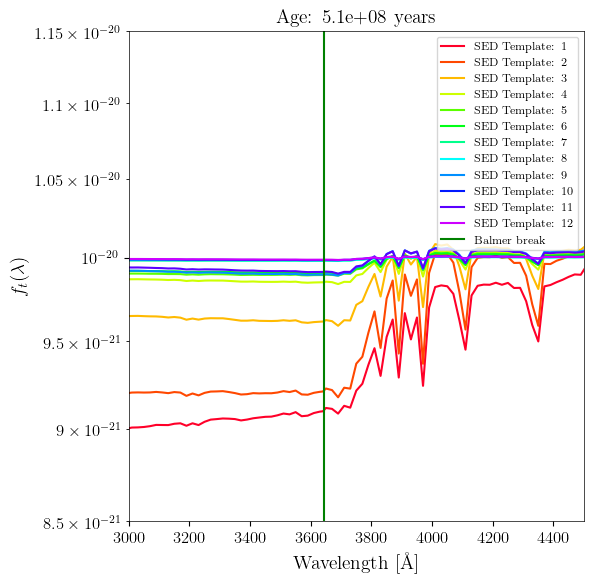

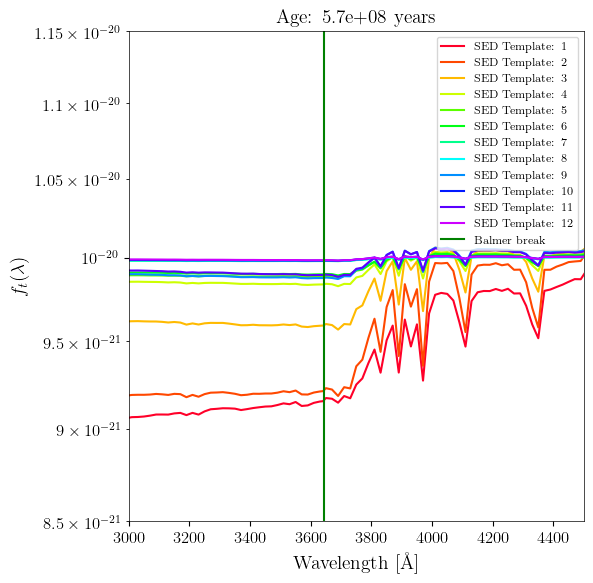

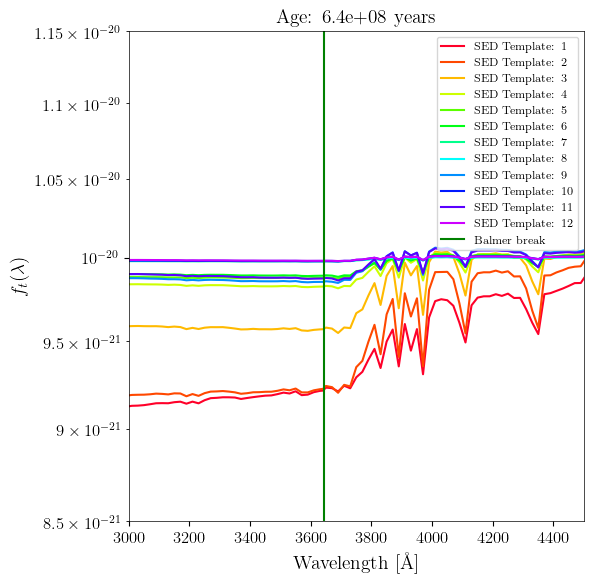

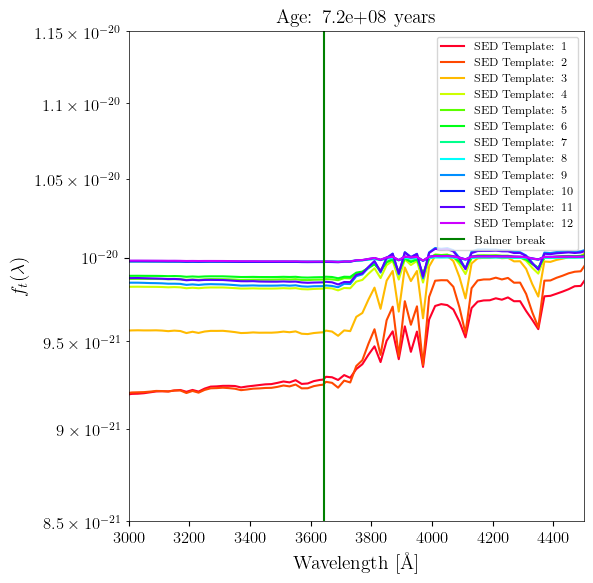

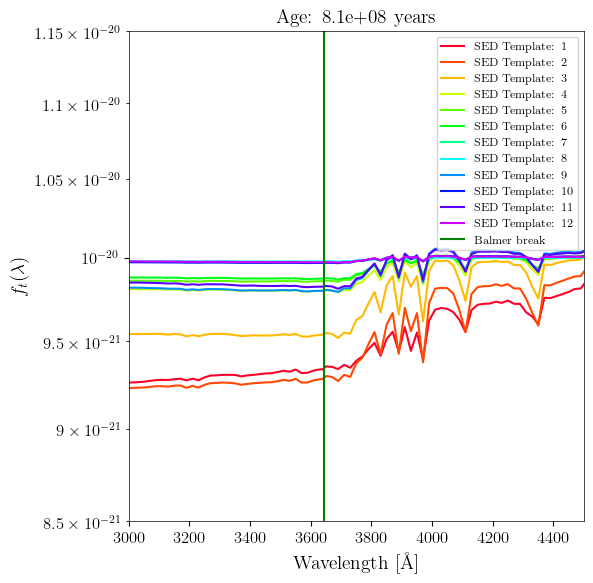

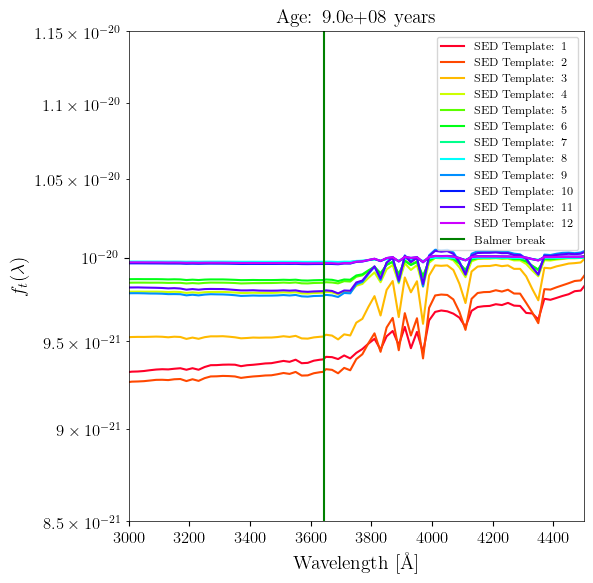

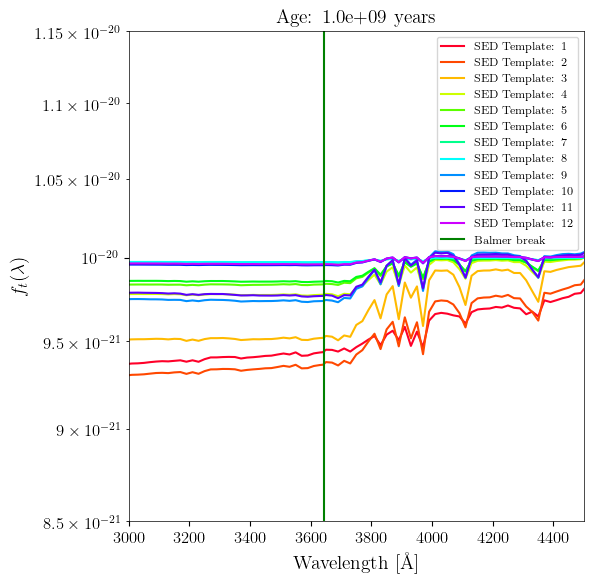

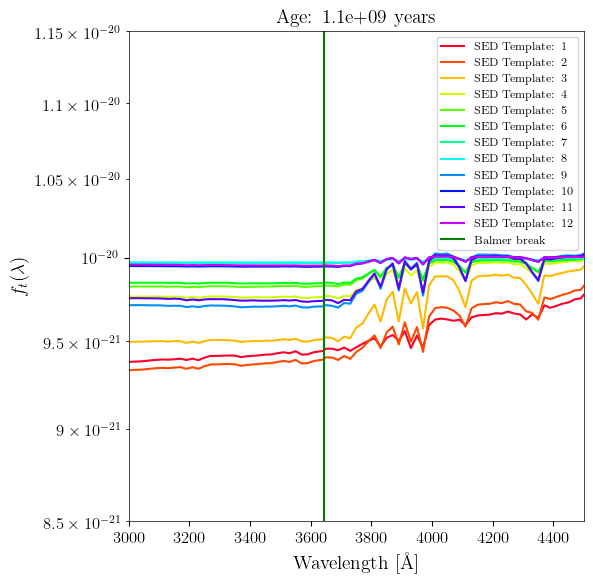

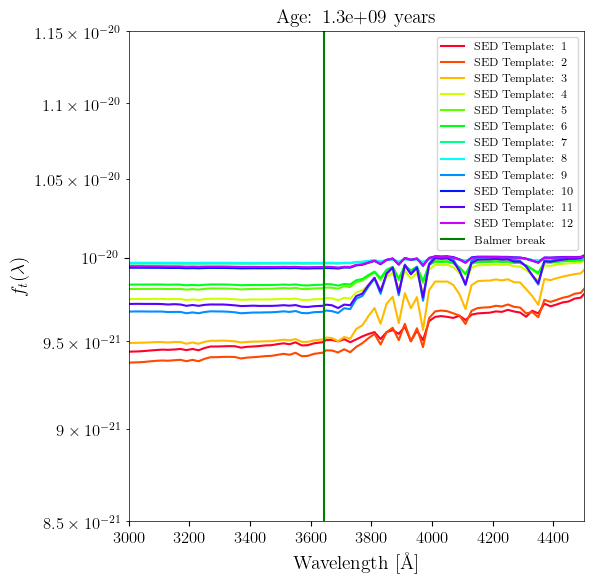

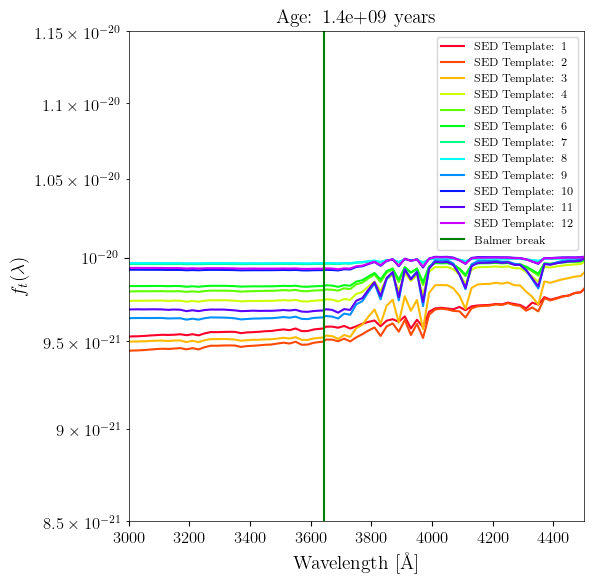

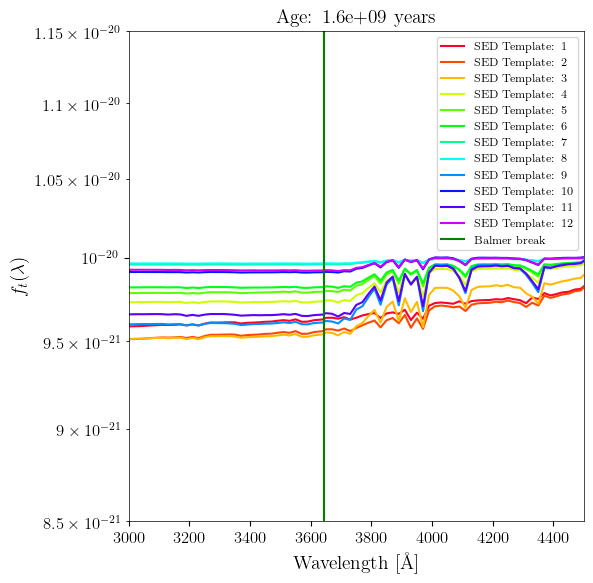

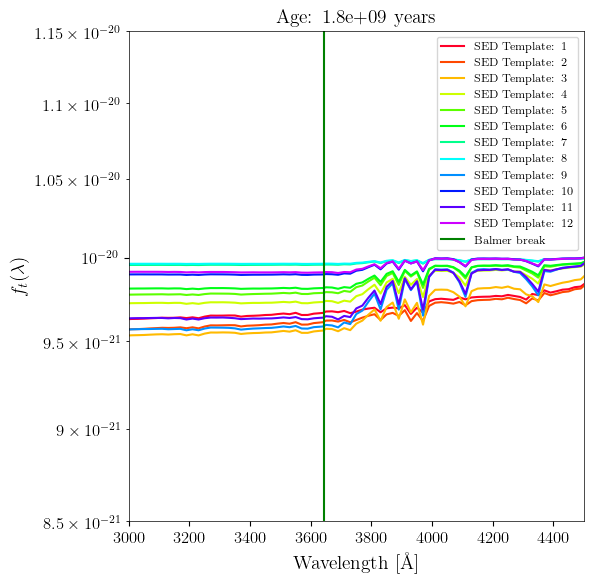

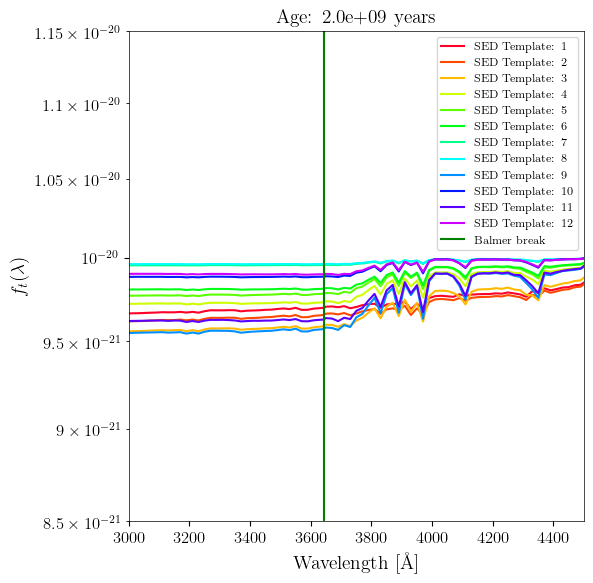

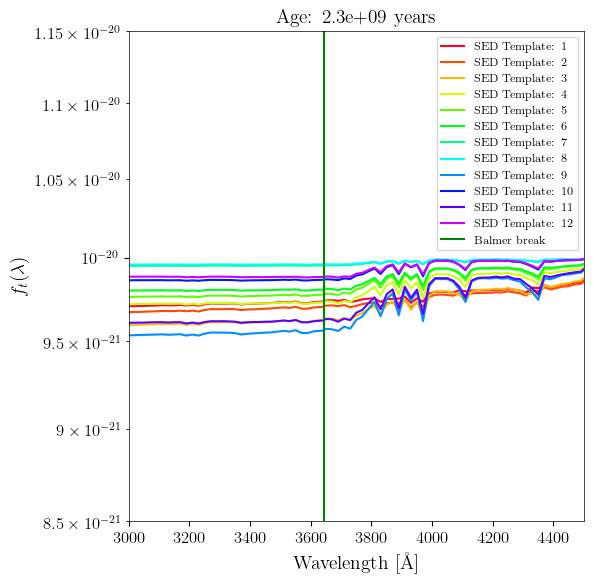

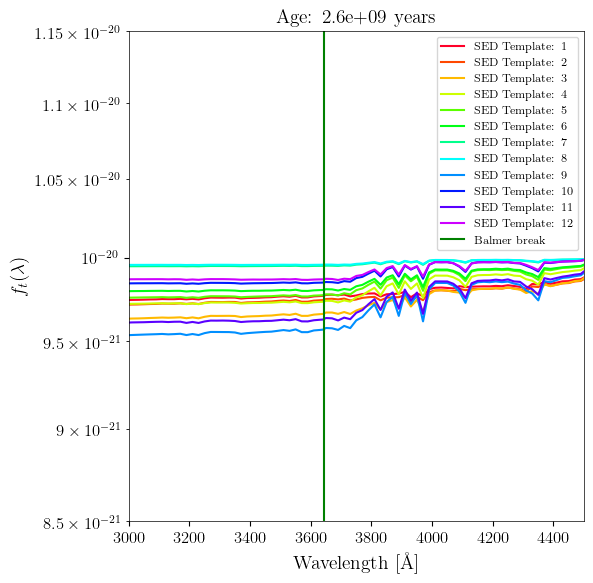

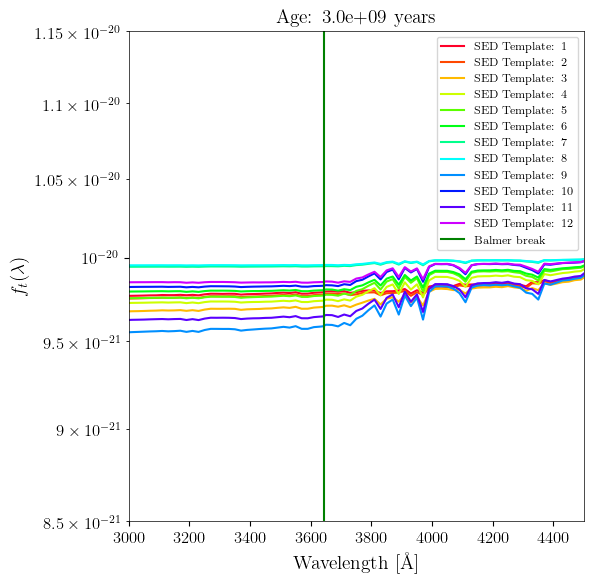

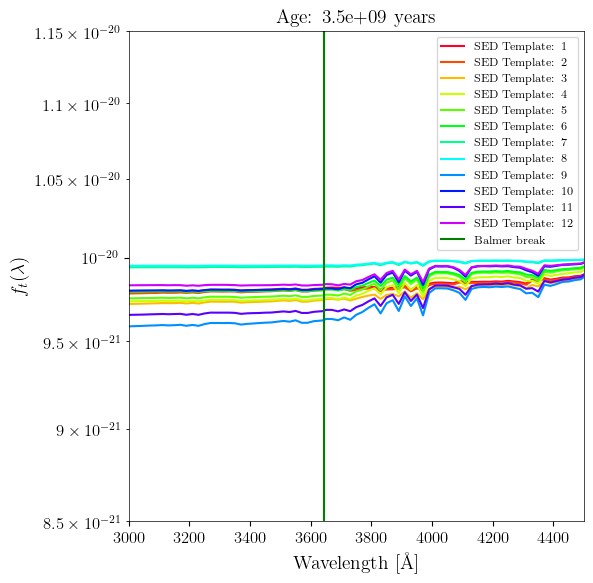

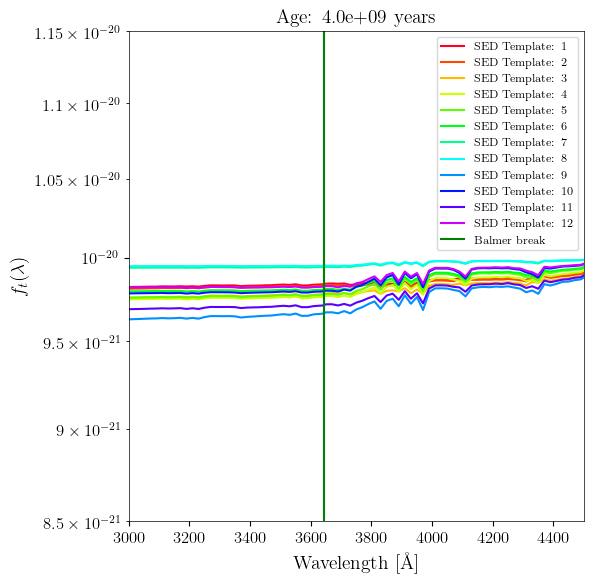

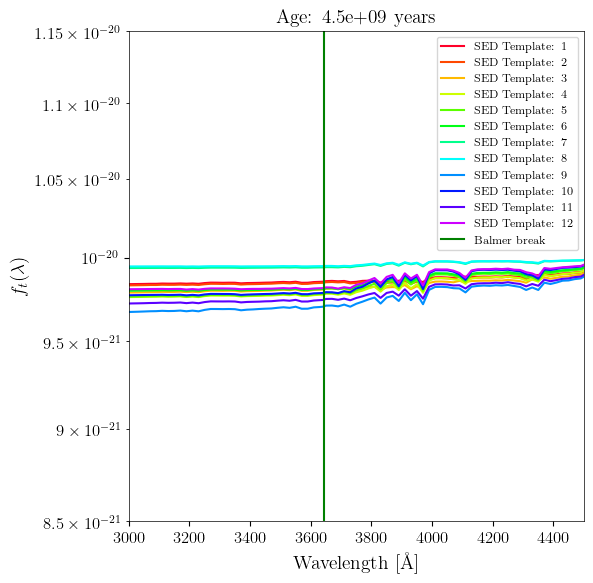

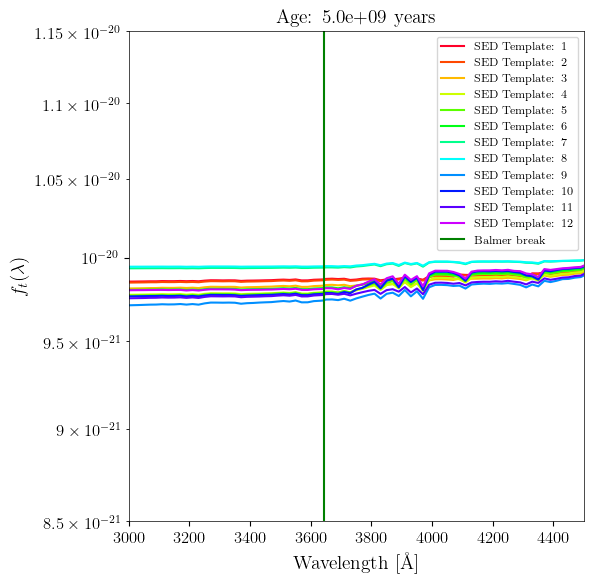

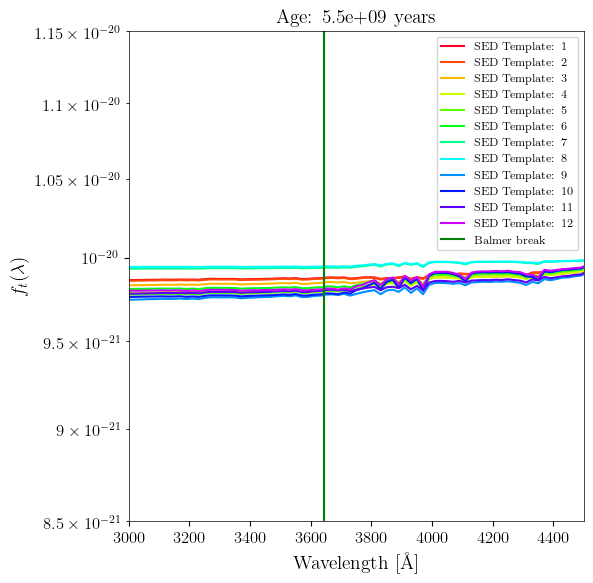

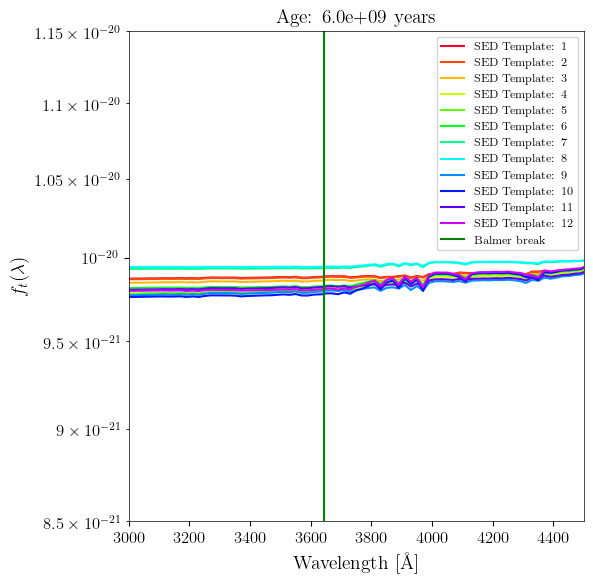

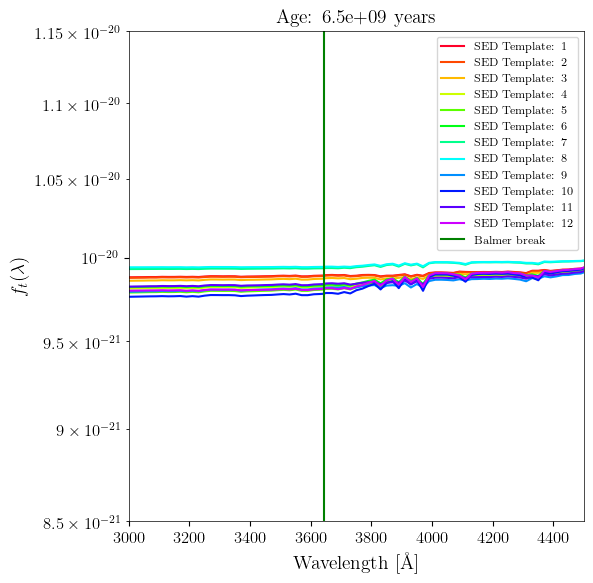

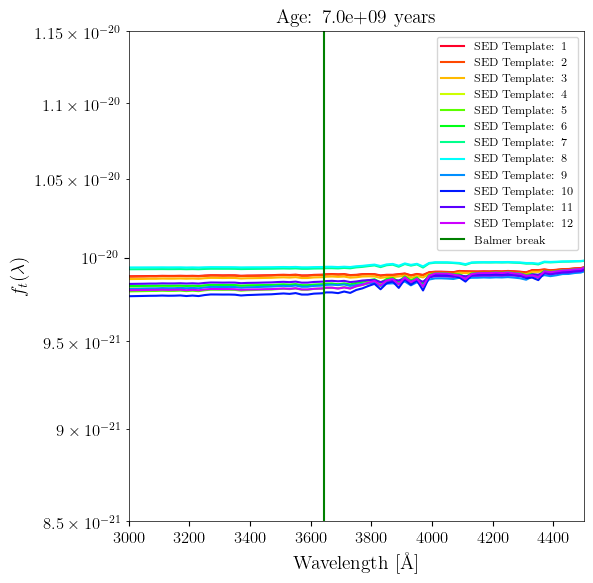

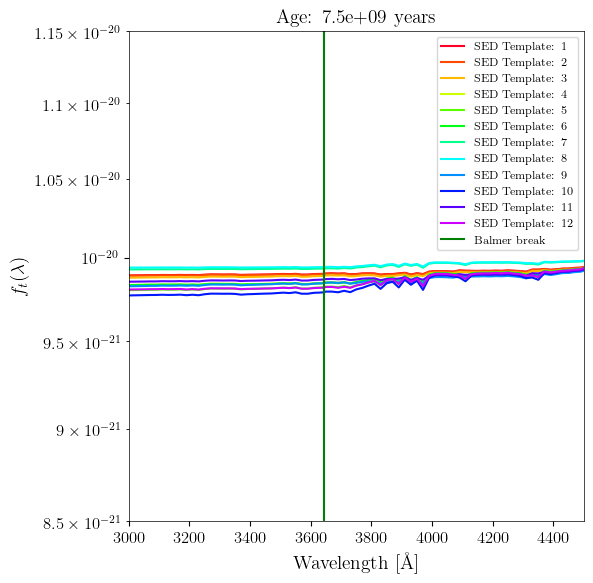

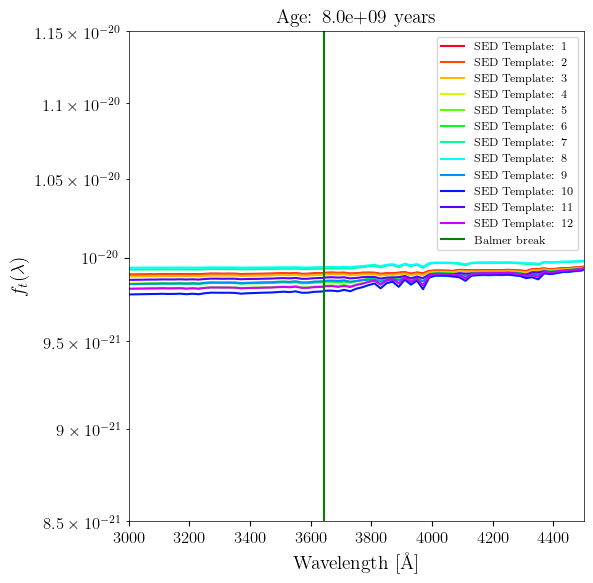

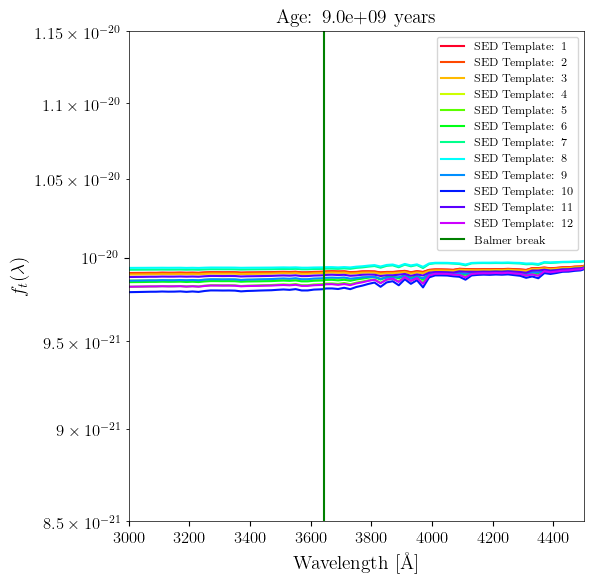

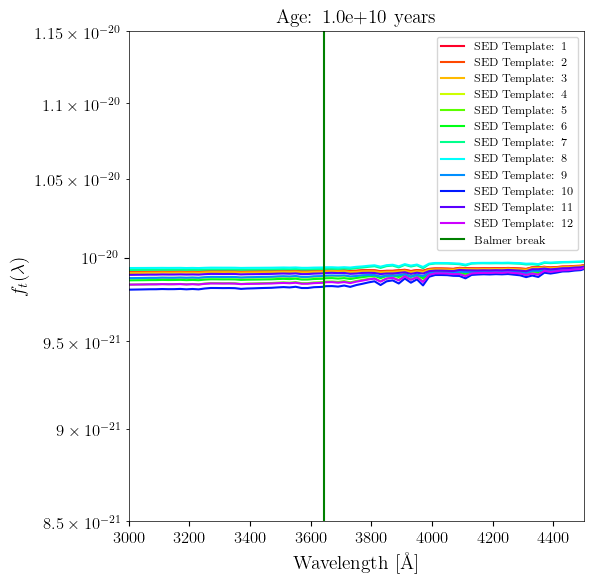

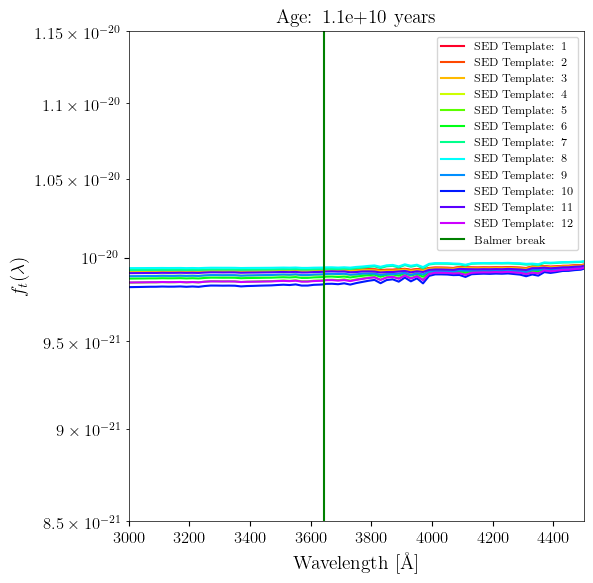

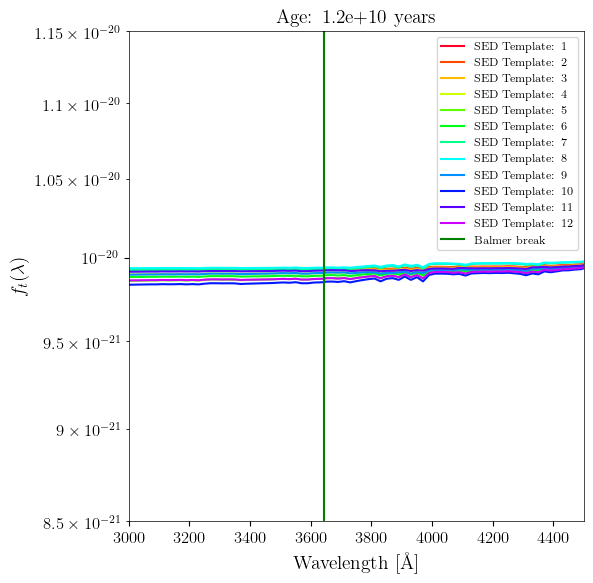

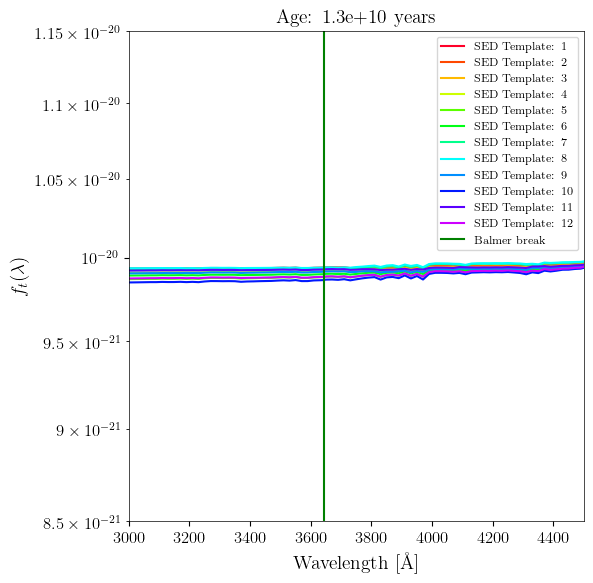

In [78]:
# DIFFERENT PLOTS, ONE FOR EACH AGE, WHERE BALMER BREAK CAN BE OBSERVED ON SOME TEMPLATES

# COLORMAP IDEA TAKEN FROM COSMOS2020-READCAT (https://github.com/cosmic-dawn/cosmos2020-readcat)
cm = plt.get_cmap('gist_rainbow')
cc = [cm(1.*i/12) for i in range(12)]

for t in range(42):
    plt.figure(figsize=(7,7))
    for m in range(1,12+1):
        plt.plot(wvl(m), fnu_mod_rescaled(m,t),c=cc[m-1],label='SED Template: '+str(m))
    plt.title('Age: '+str("%.1e"%hdf['/model{}'.format(m)].attrs['age'][t])+' years',fontsize=14)
    plt.xlabel('Wavelength [Å]')
    plt.ylabel(r'$f_t(\lambda)$')
    plt.xlim(3*10**3,4.5*10**3)
    plt.ylim(8.5*10**(-21),1.15*10**(-20))
    plt.axvline(3645,c='g',label='Balmer break')
    plt.legend(fontsize='small',loc='upper right')
    plt.yscale("log")
    
    plt.subplots_adjust(left=0.2, right=0.85, top=0.85, bottom=0.15)
    plt.savefig("%02.d"%t+".png",dpi=100,bbox_inches='tight')
    plt.show()
    plt.close()

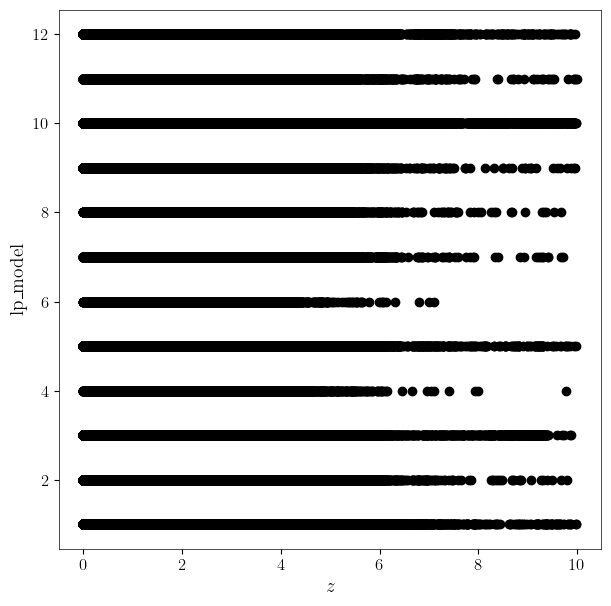

In [61]:
# LET'S SEE HOW MANY GALAXIES DO WE HAVE IN COSMOS2020 DATA AS A FUNCTION OF REDSHIFT

from astropy.table import Table 

data = Table.read(str(dir_in)+"/Processing_COSMOS2020_catalogue/COSMOS2020_Farmer_processed.fits")

plt.figure(figsize=(7,7))
plt.scatter(data['photoz'],data['lp_model'],c='k')
plt.xlabel(r'$z$')
plt.ylabel("lp_model")
plt.show()
plt.close()